In [1]:
import sys 
sys.path.append("../")
import pandas as pd

import backtester as bt

# classe principale

In [2]:
from abc import ABC, abstractmethod
import QuantLib as ql 
from datetime import date, datetime 

class Backtester(ABC):
    def __init__(self, universe, start_date, end_date, starting_balance, rebuild = False):
        self.universe = universe
        self.start_iso = start_date
        self.end_iso = end_date
        self.start_date = datetime.strptime(start_date, '%Y-%m-%d').date()
        self.end_date = datetime.strptime(end_date, '%Y-%m-%d').date()
        self.backtest_dates = bt.get_dates_between(self.start_date, self.end_date)

        self.starting_balance = starting_balance
        self.margin = {}
        self.calendar = ql.TARGET()

        self.rebuild = rebuild

        self.portfolio = bt.Portfolio()
        self.indicator = bt.Indicator()

        # crea il grid di date in base alla necessità di input se presenti o no
        self.valid_dates = []
        self.unprocessed_dates = []
        self.price_tickers = [] # aggiornano in implementazione concreta
        self.vol_tickers = []

        self.history = {}
        self.positions_summary = pd.DataFrame()
        self.period_pnl = None

    def _on_start(self):
        ''' 
        carica i market data 
        crea il grid di date
        '''
        self.market = bt.MarketData()
        self.market.load_market_data(self.rebuild)

        self._create_date_grid()
        if self.valid_dates == []:
            raise ValueError("No date available")
        self.first_date = self.valid_dates[0]
        self.last_date = self.valid_dates[-1]

    def backtest(self):
        """ chiama in automatico on_data a ogni iterazione e aggiorna history con i valori noti fino alla data"""
        self._on_start()
        self.positions_summary = pd.DataFrame()
        self.ref_dates = []
        self.ref_date = self.first_date
        for i, backtest_date in enumerate(self.valid_dates):
            try:
                self.history[backtest_date.isoformat()] = self.market.market_data[backtest_date.isoformat()]
                if backtest_date == self.first_date:
                    self.margin[backtest_date.isoformat()] = self.starting_balance
                else:
                    self.margin[backtest_date.isoformat()] = self.margin[self.valid_dates[i-1].isoformat()]

                if backtest_date == self.last_date:
                    self.ref_dates.append(backtest_date)
                    self.portfolio.close_all_positions(self.market.market_data[backtest_date.isoformat()])
                    self.margin[backtest_date.isoformat()] = 0
                else:
                    self.ref_dates.append(backtest_date.isoformat())
                    self.ref_date = self.ref_dates[-1] 
                    self.on_data()
                summary = pd.DataFrame(self.portfolio.get_positions_summary(self.market.market_data[backtest_date.isoformat()]))
                self.positions_summary = pd.concat([self.positions_summary, summary], axis = 0)

            except Exception as e:
                print("** ERROR INFO **")
                print(f"Pricing Date {backtest_date}, An error occurred: {e}")
                print("**")

        if self.positions_summary.empty:
            return
        self.period_pnl = self.positions_summary.groupby('ref_date')['global_pnl'].sum().reset_index() 
        self.period_pnl = self.period_pnl.rename(columns={'global_pnl': 'daily_pnl'})
        self.period_pnl['daily_pnl'] = self.period_pnl['daily_pnl'] + self.starting_balance

    def _create_date_grid(self):
        for backtest_date in self.backtest_dates:
            if self.calendar.isHoliday(ql.Date.from_date(backtest_date)):
                continue
            try:
                [self.market.market_data[backtest_date.isoformat()]['equity'][p]['close'] for p in self.price_tickers]
            except:
                self.unprocessed_dates.append(backtest_date)
                continue
            try:
                [self.market.market_data[backtest_date.isoformat()]['volatility'][p] for p in self.vol_tickers]
            except:
                self.unprocessed_dates.append(backtest_date)
                continue
            self.valid_dates.append(backtest_date)

    def get_data_at(self, ref_date: str):
        history = {}
        for backtest_date in self.valid_dates:
            if backtest_date > datetime.strptime(ref_date, '%Y-%m-%d').date():
                break 
            history[backtest_date.isoformat()] = self.market.market_data[backtest_date.isoformat()]
        return history

    def buy_equity(self, ticker, quantity, market):
        """ compra se c'è  margine disponibile"""
        position = bt.EquityPosition(ticker, quantity, market, bt.PositionType.LONG)
        available_margin = self.margin[position.trade_date]
        # position_ctv = position.entry_price * position.quantity
        if position.initial_ctv <= available_margin:
            self.portfolio.add_position(position)
            self.margin[position.trade_date] = available_margin - position.initial_ctv
        return
    
    def close_equity(self, position, market):
        self.margin[market['ref_date']] = self.margin[market['ref_date']] + position.calculate_ctv(market)
        position.close_position(market)
        return


    @abstractmethod
    def on_data(self):
        """
        Implement trading logic.
        """
        pass


class BuyHoldStrategy(Backtester):
    def __init__(self, universe, start_date, end_date, starting_balance):
        super().__init__(universe, start_date, end_date, starting_balance)
        self.position_open = False   
        self.price_tickers = ['ISP_IM_Equity']


    def on_data(self):
        mkt = self.history[self.ref_date]
        # close_price = mkt['equity']['ISP_IM_Equity']['close']

        if not self.position_open:
            self.buy_equity(ticker='ISP_IM_Equity', quantity=1, market=mkt)
            self.position_open = True

        if self.ref_date == "2023-12-27":
            eq_position = self.portfolio.get_positions('ISP_IM_Equity', bt.AssetType.EQUITY)[0]
            self.close_equity(eq_position, mkt)

In [3]:
universe = ['ISP_IM_Equity']
backtester = BuyHoldStrategy(universe, '2015-01-01', '2024-12-31', starting_balance=10)

In [4]:
backtester.backtest()
res = bt.ResultAnalyzer(backtester.positions_summary, backtester.period_pnl)

# output

In [ ]:
res.summary()

{'Expected Return': '0.000003',
 'Std Deviation': '0.004029',
 'Sharpe Ratio': '0.000651',
 'N. Trade': 1,
 'Win Rate': '0.000000',
 'Average P&L': '-0.097500',
 'Average Win': 'nan',
 'Average Loss': '-0.097500',
 'Max Profit': '0.000000',
 'Max Loss': '-0.097500',
 'Profit Factor': '0.000000',
 'Max Drawdown': '-0.180757'}

In [8]:
res.get_trade_log()

,ref_date,trade_date,trade_id,symbol,type,side,quantity,entry_price,is_alive,current_value,open_pnl,closed_pnl,global_pnl
0,2018-01-02,2018-01-02,74809,ISP_IM_Equity,equity,1,1,2.754,True,2.7540,0.0,0.0000,0.0000
1,2023-12-27,2018-01-02,74809,ISP_IM_Equity,equity,1,0,2.754,False,2.6565,0.0,-0.0975,-0.0975


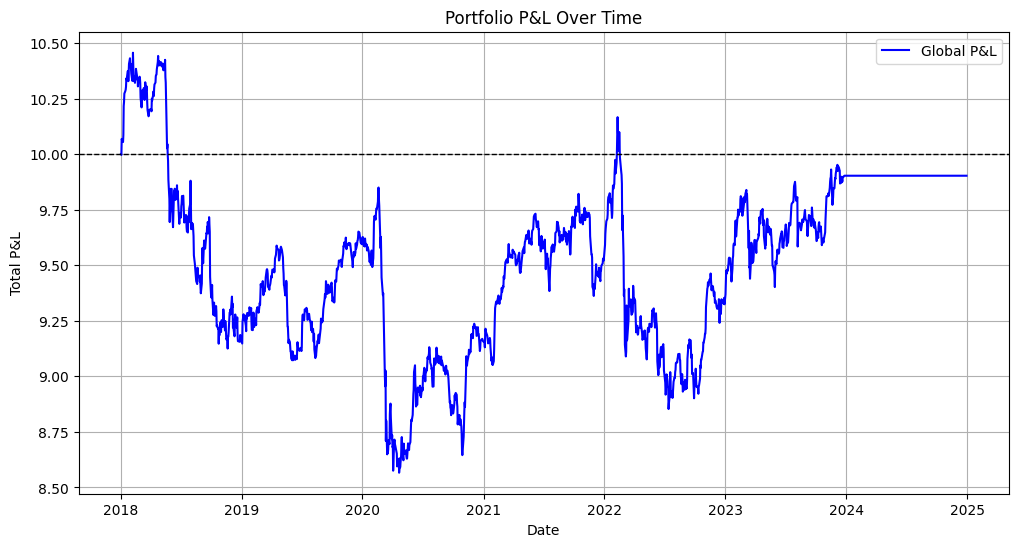

In [9]:
res.plot_pnl()